# Embed and Predict (BoW)

We treat each document as a Bag of Words (BoW), and just average the GloVe word embeddings to create document vectors, and run them through a 2 layer classifier network.

In [1]:
from __future__ import division, print_function
from keras.layers import Input
from keras.layers.core import Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
import numpy as np
import logging
import os
%matplotlib inline
nltk.download('punkt')

Using TensorFlow backend.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
DATA_DIR = "../data"

VOCAB_FILE = os.path.join(DATA_DIR, "ng-vocab.tsv")
MIN_OCCURS = 5

GLOVE_FILE = os.path.join(DATA_DIR, "glove.840B.300d.txt")
WORD_EMBED_SIZE = 300

NUM_CLASSES = 20
BATCH_SIZE = 64
NUM_EPOCHS = 1000

logging.basicConfig()

## Load Vocabulary

In [4]:
word2id = {"PAD": 0, "UNK": 1}
fvocab = open(VOCAB_FILE, "rb")
for i, line in enumerate(fvocab):
    word, count = line.decode('utf-8').strip().split("\t")
    # 如果word出現的次數= MIN_OCCURS，不列入資料集
    if int(count) <= MIN_OCCURS:
        break
    word2id[word] = i
#print(word2id)
fvocab.close()
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)
print("vocab_size: {:d}".format(vocab_size))

vocab_size: 40683


## Load GloVe embeddings

In [ ]:
E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "rb")
#print(fglove[0])
gg=[]
for line in fglove:
    cols = line.decode('utf-8').strip().split(" ")
    gg.append(cols)
    '''
    word = cols[0]
    if not word in word2id:
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    E[idx] = vec
    '''
fglove.close()
print(gg)
print(E)
print(E.shape)

In [11]:
E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "rb")
#print(fglove[0])
for line in fglove:
    cols = line.decode('utf-8').strip().split(" ")
    word = cols[0]
    if not word in word2id:
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    E[idx] = vec
fglove.close()
print(E)
print(E.shape)

[[ 0.10179    0.5278     0.12629   ... -0.27129    0.33692   -0.89222  ]
 [ 0.82303   -0.4862     0.1664    ...  0.12718    0.44752   -0.076716 ]
 [ 0.27204   -0.06203   -0.1884    ...  0.13015   -0.18317    0.1323   ]
 ...
 [ 0.045006   0.51507    0.0097176 ...  0.17027   -0.22514   -0.10333  ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]
 [ 0.         0.         0.        ...  0.         0.         0.       ]]
(40683, 300)


## Compute Document Vectors

In [43]:
ng_data = fetch_20newsgroups(subset='all',
                             data_home=DATA_DIR,
                             shuffle=True, 
                             random_state=42)
num_docs = len(ng_data.data)
print(num_docs)

18846


In [44]:
D = np.zeros((num_docs, WORD_EMBED_SIZE))
for i, text in enumerate(ng_data.data):
    doc_vec = np.zeros(WORD_EMBED_SIZE)
    num_words = 0
    for sent in nltk.sent_tokenize(text):
        sent = sent.encode("utf8").decode("ascii", "ignore").lower()
        for word in nltk.word_tokenize(sent):
            try:
                doc_vec += E[word2id[word]]
            except KeyError:
                doc_vec += E[word2id["UNK"]]
            num_words += 1
    doc_vec /= num_words
    D[i] = doc_vec
print(D.shape)

(18846, 300)


## Data Generation

In [45]:
y = ng_data.target
Y = to_categorical(y, num_classes=NUM_CLASSES)
print(Y.shape)

(18846, 20)


In [46]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(D, Y, train_size=0.7)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(13192, 300) (13192, 20) (5654, 300) (5654, 20)


## Define Network

In [47]:
inputs = Input(shape=(WORD_EMBED_SIZE, ))
fc1 = Dense(100, activation="relu")(inputs)
fc1_dropout = Dropout(0.2)(fc1)
fc2 = Dense(50, activation="relu")(fc1_dropout)
fc2_dropout = Dropout(0.2)(fc2)
outputs = Dense(NUM_CLASSES, activation="softmax")(fc1_dropout)

In [48]:
model = Model(inputs=inputs, outputs=outputs)

In [49]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
             metrics=["accuracy"])

In [50]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 20)                2020      
Total params: 32,120
Trainable params: 32,120
Non-trainable params: 0
_________________________________________________________________


## Train Network

In [58]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, validation_split=0.1)

Train on 11872 samples, validate on 1320 samples
Epoch 1/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.5779 - acc: 0.1615 - val_loss: 2.5295 - val_acc: 0.1939
Epoch 2/1000
11872/11872 [==============================] - 0s 37us/step - loss: 2.5782 - acc: 0.1546 - val_loss: 2.5065 - val_acc: 0.1803
Epoch 3/1000
11872/11872 [==============================] - 0s 38us/step - loss: 2.5876 - acc: 0.1556 - val_loss: 2.4911 - val_acc: 0.1932
Epoch 4/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.5854 - acc: 0.1536 - val_loss: 2.5040 - val_acc: 0.2068
Epoch 5/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.5770 - acc: 0.1569 - val_loss: 2.4887 - val_acc: 0.1841
Epoch 6/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.5728 - acc: 0.1555 - val_loss: 2.5211 - val_acc: 0.1894
Epoch 7/1000
11872/11872 [==============================] - 0s 42us/step - loss: 2.5819 - acc: 0.1564 - val_loss: 2.4

11872/11872 [==============================] - 0s 42us/step - loss: 2.5128 - acc: 0.1802 - val_loss: 2.3928 - val_acc: 0.2311
Epoch 118/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.5013 - acc: 0.1805 - val_loss: 2.3889 - val_acc: 0.2106
Epoch 119/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.5102 - acc: 0.1798 - val_loss: 2.4029 - val_acc: 0.2220
Epoch 120/1000
11872/11872 [==============================] - 0s 42us/step - loss: 2.5119 - acc: 0.1781 - val_loss: 2.3892 - val_acc: 0.2242
Epoch 121/1000
11872/11872 [==============================] - 1s 42us/step - loss: 2.5165 - acc: 0.1824 - val_loss: 2.3922 - val_acc: 0.2189
Epoch 122/1000
11872/11872 [==============================] - 0s 42us/step - loss: 2.5167 - acc: 0.1749 - val_loss: 2.4138 - val_acc: 0.2083
Epoch 123/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.5151 - acc: 0.1794 - val_loss: 2.3853 - val_acc: 0.2205
Epoch 124/1000
11872/11872 [

11872/11872 [==============================] - 0s 39us/step - loss: 2.4777 - acc: 0.1930 - val_loss: 2.3284 - val_acc: 0.2409
Epoch 234/1000
11872/11872 [==============================] - 0s 38us/step - loss: 2.4807 - acc: 0.1963 - val_loss: 2.3459 - val_acc: 0.2515
Epoch 235/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4831 - acc: 0.1933 - val_loss: 2.3225 - val_acc: 0.2417
Epoch 236/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.4763 - acc: 0.1936 - val_loss: 2.3316 - val_acc: 0.2447
Epoch 237/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4790 - acc: 0.1954 - val_loss: 2.3462 - val_acc: 0.2258
Epoch 238/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4692 - acc: 0.1983 - val_loss: 2.3485 - val_acc: 0.2439
Epoch 239/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4837 - acc: 0.1934 - val_loss: 2.3541 - val_acc: 0.2470
Epoch 240/1000
11872/11872 [

11872/11872 [==============================] - 0s 36us/step - loss: 2.4577 - acc: 0.2090 - val_loss: 2.3123 - val_acc: 0.2614
Epoch 350/1000
11872/11872 [==============================] - 0s 38us/step - loss: 2.4556 - acc: 0.2048 - val_loss: 2.2963 - val_acc: 0.2652
Epoch 351/1000
11872/11872 [==============================] - 0s 37us/step - loss: 2.4571 - acc: 0.2049 - val_loss: 2.2898 - val_acc: 0.2674
Epoch 352/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4647 - acc: 0.2026 - val_loss: 2.3169 - val_acc: 0.2674
Epoch 353/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4461 - acc: 0.2068 - val_loss: 2.3113 - val_acc: 0.2697
Epoch 354/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.4497 - acc: 0.2062 - val_loss: 2.2906 - val_acc: 0.2667
Epoch 355/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4433 - acc: 0.2126 - val_loss: 2.3331 - val_acc: 0.2462
Epoch 356/1000
11872/11872 [

11872/11872 [==============================] - 0s 39us/step - loss: 2.4315 - acc: 0.2139 - val_loss: 2.2853 - val_acc: 0.2652
Epoch 466/1000
11872/11872 [==============================] - 0s 42us/step - loss: 2.4431 - acc: 0.2115 - val_loss: 2.3025 - val_acc: 0.2659
Epoch 467/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.4391 - acc: 0.2091 - val_loss: 2.2752 - val_acc: 0.2697
Epoch 468/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.4422 - acc: 0.2139 - val_loss: 2.2695 - val_acc: 0.2826
Epoch 469/1000
11872/11872 [==============================] - 0s 36us/step - loss: 2.4379 - acc: 0.2127 - val_loss: 2.2927 - val_acc: 0.2598
Epoch 470/1000
11872/11872 [==============================] - 0s 42us/step - loss: 2.4445 - acc: 0.2136 - val_loss: 2.3068 - val_acc: 0.2636
Epoch 471/1000
11872/11872 [==============================] - 1s 42us/step - loss: 2.4447 - acc: 0.2130 - val_loss: 2.2748 - val_acc: 0.2720
Epoch 472/1000
11872/11872 [

11872/11872 [==============================] - 0s 38us/step - loss: 2.4291 - acc: 0.2194 - val_loss: 2.3060 - val_acc: 0.2447
Epoch 582/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4405 - acc: 0.2134 - val_loss: 2.2563 - val_acc: 0.2818
Epoch 583/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4255 - acc: 0.2134 - val_loss: 2.2790 - val_acc: 0.2864
Epoch 584/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4265 - acc: 0.2143 - val_loss: 2.2725 - val_acc: 0.2795
Epoch 585/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4179 - acc: 0.2189 - val_loss: 2.2262 - val_acc: 0.2894
Epoch 586/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4237 - acc: 0.2188 - val_loss: 2.2836 - val_acc: 0.2795
Epoch 587/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.4250 - acc: 0.2146 - val_loss: 2.2620 - val_acc: 0.2780
Epoch 588/1000
11872/11872 [

11872/11872 [==============================] - 0s 40us/step - loss: 2.4114 - acc: 0.2203 - val_loss: 2.2246 - val_acc: 0.2962
Epoch 698/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.3972 - acc: 0.2254 - val_loss: 2.2209 - val_acc: 0.2955
Epoch 699/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4026 - acc: 0.2251 - val_loss: 2.2438 - val_acc: 0.2864
Epoch 700/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4154 - acc: 0.2197 - val_loss: 2.2615 - val_acc: 0.2803
Epoch 701/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.4228 - acc: 0.2239 - val_loss: 2.2360 - val_acc: 0.2848
Epoch 702/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4108 - acc: 0.2198 - val_loss: 2.2404 - val_acc: 0.2848
Epoch 703/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4107 - acc: 0.2238 - val_loss: 2.2194 - val_acc: 0.2924
Epoch 704/1000
11872/11872 [

11872/11872 [==============================] - 0s 40us/step - loss: 2.4052 - acc: 0.2203 - val_loss: 2.2298 - val_acc: 0.2909
Epoch 814/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4159 - acc: 0.2200 - val_loss: 2.2145 - val_acc: 0.2917
Epoch 815/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4157 - acc: 0.2218 - val_loss: 2.2481 - val_acc: 0.2742
Epoch 816/1000
11872/11872 [==============================] - 0s 39us/step - loss: 2.3976 - acc: 0.2253 - val_loss: 2.2208 - val_acc: 0.3000
Epoch 817/1000
11872/11872 [==============================] - 0s 42us/step - loss: 2.4018 - acc: 0.2251 - val_loss: 2.2014 - val_acc: 0.2947
Epoch 818/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4030 - acc: 0.2209 - val_loss: 2.2745 - val_acc: 0.2727
Epoch 819/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.4054 - acc: 0.2231 - val_loss: 2.2064 - val_acc: 0.2962
Epoch 820/1000
11872/11872 [

11872/11872 [==============================] - 1s 43us/step - loss: 2.3896 - acc: 0.2262 - val_loss: 2.1889 - val_acc: 0.3045
Epoch 930/1000
11872/11872 [==============================] - 1s 44us/step - loss: 2.3940 - acc: 0.2262 - val_loss: 2.2107 - val_acc: 0.3000
Epoch 931/1000
11872/11872 [==============================] - 1s 44us/step - loss: 2.3968 - acc: 0.2273 - val_loss: 2.1913 - val_acc: 0.3038
Epoch 932/1000
11872/11872 [==============================] - 0s 41us/step - loss: 2.4008 - acc: 0.2287 - val_loss: 2.2047 - val_acc: 0.2917
Epoch 933/1000
11872/11872 [==============================] - 0s 40us/step - loss: 2.3949 - acc: 0.2257 - val_loss: 2.2398 - val_acc: 0.2856
Epoch 934/1000
11872/11872 [==============================] - 0s 36us/step - loss: 2.3942 - acc: 0.2155 - val_loss: 2.2270 - val_acc: 0.2894
Epoch 935/1000
11872/11872 [==============================] - 0s 37us/step - loss: 2.4007 - acc: 0.2255 - val_loss: 2.2381 - val_acc: 0.2848
Epoch 936/1000
11872/11872 [

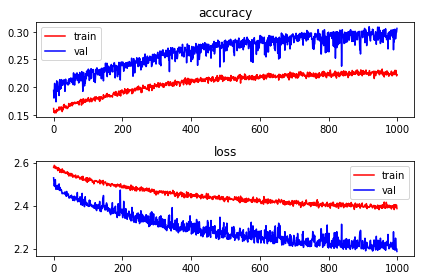

In [59]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [24]:
np.set_printoptions(linewidth=120)
Ytest_ = model.predict(Xtest)
ytest_ = np.argmax(Ytest_, axis=1)
ytest = np.argmax(Ytest, axis=1)
print("accuracy score: {:.3f}".format(accuracy_score(ytest, ytest_)))
print("\nconfusion matrix\n")
print(confusion_matrix(ytest, ytest_))

accuracy score: 0.051

confusion matrix

[[  0   0   0   0   0   0   0   0 256   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 291   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 277   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 283   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 288   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 302   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 287   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 284   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 290   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 307   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 304   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 294   0   0 

In [24]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# prepare sequence
length = 5
seq = array([i/float(length) for i in range(length)])
X = seq.reshape(len(seq), 1, 1)
y = seq.reshape(len(seq), 1)
# define LSTM configuration
n_neurons = length
n_batch = length
n_epoch = 1000
# create LSTM
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
# train LSTM
model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=2)
# evaluate
result = model.predict(X, batch_size=n_batch, verbose=0)
for value in result:
	print('%.1f' % value)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 5)                 140       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
 - 2s - loss: 0.2452
Epoch 2/1000
 - 0s - loss: 0.2439
Epoch 3/1000
 - 0s - loss: 0.2423
Epoch 4/1000
 - 0s - loss: 0.2407
Epoch 5/1000
 - 0s - loss: 0.2390
Epoch 6/1000
 - 0s - loss: 0.2373
Epoch 7/1000
 - 0s - loss: 0.2356
Epoch 8/1000
 - 0s - loss: 0.2338
Epoch 9/1000
 - 0s - loss: 0.2321
Epoch 10/1000
 - 0s - loss: 0.2304
Epoch 11/1000
 - 0s - loss: 0.2287
Epoch 12/1000
 - 0s - loss: 0.2269
Epoch 13/1000
 - 0s - loss: 0.2252
Epoch 14/1000
 - 0s - loss: 0.2235
Epoch 15/1000
 - 0s - loss: 0.2218
Epoch 16/1000
 - 0s

Epoch 215/1000
 - 0s - loss: 0.0573
Epoch 216/1000
 - 0s - loss: 0.0570
Epoch 217/1000
 - 0s - loss: 0.0568
Epoch 218/1000
 - 0s - loss: 0.0565
Epoch 219/1000
 - 0s - loss: 0.0563
Epoch 220/1000
 - 0s - loss: 0.0561
Epoch 221/1000
 - 0s - loss: 0.0558
Epoch 222/1000
 - 0s - loss: 0.0556
Epoch 223/1000
 - 0s - loss: 0.0554
Epoch 224/1000
 - 0s - loss: 0.0552
Epoch 225/1000
 - 0s - loss: 0.0549
Epoch 226/1000
 - 0s - loss: 0.0547
Epoch 227/1000
 - 0s - loss: 0.0545
Epoch 228/1000
 - 0s - loss: 0.0543
Epoch 229/1000
 - 0s - loss: 0.0541
Epoch 230/1000
 - 0s - loss: 0.0539
Epoch 231/1000
 - 0s - loss: 0.0537
Epoch 232/1000
 - 0s - loss: 0.0535
Epoch 233/1000
 - 0s - loss: 0.0533
Epoch 234/1000
 - 0s - loss: 0.0531
Epoch 235/1000
 - 0s - loss: 0.0529
Epoch 236/1000
 - 0s - loss: 0.0527
Epoch 237/1000
 - 0s - loss: 0.0525
Epoch 238/1000
 - 0s - loss: 0.0524
Epoch 239/1000
 - 0s - loss: 0.0522
Epoch 240/1000
 - 0s - loss: 0.0520
Epoch 241/1000
 - 0s - loss: 0.0518
Epoch 242/1000
 - 0s - loss:

Epoch 443/1000
 - 0s - loss: 0.0301
Epoch 444/1000
 - 0s - loss: 0.0300
Epoch 445/1000
 - 0s - loss: 0.0299
Epoch 446/1000
 - 0s - loss: 0.0298
Epoch 447/1000
 - 0s - loss: 0.0297
Epoch 448/1000
 - 0s - loss: 0.0296
Epoch 449/1000
 - 0s - loss: 0.0295
Epoch 450/1000
 - 0s - loss: 0.0294
Epoch 451/1000
 - 0s - loss: 0.0293
Epoch 452/1000
 - 0s - loss: 0.0292
Epoch 453/1000
 - 0s - loss: 0.0291
Epoch 454/1000
 - 0s - loss: 0.0290
Epoch 455/1000
 - 0s - loss: 0.0289
Epoch 456/1000
 - 0s - loss: 0.0288
Epoch 457/1000
 - 0s - loss: 0.0287
Epoch 458/1000
 - 0s - loss: 0.0286
Epoch 459/1000
 - 0s - loss: 0.0285
Epoch 460/1000
 - 0s - loss: 0.0284
Epoch 461/1000
 - 0s - loss: 0.0283
Epoch 462/1000
 - 0s - loss: 0.0282
Epoch 463/1000
 - 0s - loss: 0.0281
Epoch 464/1000
 - 0s - loss: 0.0280
Epoch 465/1000
 - 0s - loss: 0.0279
Epoch 466/1000
 - 0s - loss: 0.0278
Epoch 467/1000
 - 0s - loss: 0.0277
Epoch 468/1000
 - 0s - loss: 0.0276
Epoch 469/1000
 - 0s - loss: 0.0275
Epoch 470/1000
 - 0s - loss:

Epoch 671/1000
 - 0s - loss: 0.0093
Epoch 672/1000
 - 0s - loss: 0.0093
Epoch 673/1000
 - 0s - loss: 0.0092
Epoch 674/1000
 - 0s - loss: 0.0091
Epoch 675/1000
 - 0s - loss: 0.0091
Epoch 676/1000
 - 0s - loss: 0.0090
Epoch 677/1000
 - 0s - loss: 0.0089
Epoch 678/1000
 - 0s - loss: 0.0089
Epoch 679/1000
 - 0s - loss: 0.0088
Epoch 680/1000
 - 0s - loss: 0.0087
Epoch 681/1000
 - 0s - loss: 0.0087
Epoch 682/1000
 - 0s - loss: 0.0086
Epoch 683/1000
 - 0s - loss: 0.0085
Epoch 684/1000
 - 0s - loss: 0.0085
Epoch 685/1000
 - 0s - loss: 0.0084
Epoch 686/1000
 - 0s - loss: 0.0083
Epoch 687/1000
 - 0s - loss: 0.0083
Epoch 688/1000
 - 0s - loss: 0.0082
Epoch 689/1000
 - 0s - loss: 0.0081
Epoch 690/1000
 - 0s - loss: 0.0081
Epoch 691/1000
 - 0s - loss: 0.0080
Epoch 692/1000
 - 0s - loss: 0.0079
Epoch 693/1000
 - 0s - loss: 0.0079
Epoch 694/1000
 - 0s - loss: 0.0078
Epoch 695/1000
 - 0s - loss: 0.0077
Epoch 696/1000
 - 0s - loss: 0.0077
Epoch 697/1000
 - 0s - loss: 0.0076
Epoch 698/1000
 - 0s - loss:

Epoch 898/1000
 - 0s - loss: 8.5684e-04
Epoch 899/1000
 - 0s - loss: 8.4570e-04
Epoch 900/1000
 - 0s - loss: 8.3469e-04
Epoch 901/1000
 - 0s - loss: 8.2382e-04
Epoch 902/1000
 - 0s - loss: 8.1309e-04
Epoch 903/1000
 - 0s - loss: 8.0248e-04
Epoch 904/1000
 - 0s - loss: 7.9201e-04
Epoch 905/1000
 - 0s - loss: 7.8167e-04
Epoch 906/1000
 - 0s - loss: 7.7146e-04
Epoch 907/1000
 - 0s - loss: 7.6138e-04
Epoch 908/1000
 - 0s - loss: 7.5142e-04
Epoch 909/1000
 - 0s - loss: 7.4159e-04
Epoch 910/1000
 - 0s - loss: 7.3189e-04
Epoch 911/1000
 - 0s - loss: 7.2230e-04
Epoch 912/1000
 - 0s - loss: 7.1284e-04
Epoch 913/1000
 - 0s - loss: 7.0350e-04
Epoch 914/1000
 - 0s - loss: 6.9429e-04
Epoch 915/1000
 - 0s - loss: 6.8518e-04
Epoch 916/1000
 - 0s - loss: 6.7620e-04
Epoch 917/1000
 - 0s - loss: 6.6733e-04
Epoch 918/1000
 - 0s - loss: 6.5858e-04
Epoch 919/1000
 - 0s - loss: 6.4994e-04
Epoch 920/1000
 - 0s - loss: 6.4141e-04
Epoch 921/1000
 - 0s - loss: 6.3300e-04
Epoch 922/1000
 - 0s - loss: 6.2469e-04


In [25]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# prepare sequence
length = 5
seq = array([i/float(length) for i in range(length)])
X = seq.reshape(1, length, 1)
y = seq.reshape(1, length)
# define LSTM configuration
n_neurons = length
n_batch = 1
n_epoch = 500
# create LSTM
model = Sequential()
model.add(LSTM(n_neurons, input_shape=(length, 1)))
model.add(Dense(length))
model.compile(loss='mean_squared_error', optimizer='adam')
print(model.summary())
# train LSTM
model.fit(X, y, epochs=n_epoch, batch_size=n_batch, verbose=2)
# evaluate
result = model.predict(X, batch_size=n_batch, verbose=0)
for value in result[0,:]:
	print('%.1f' % value)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 5)                 140       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 30        
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
 - 2s - loss: 0.2144
Epoch 2/500
 - 0s - loss: 0.2130
Epoch 3/500
 - 0s - loss: 0.2114
Epoch 4/500
 - 0s - loss: 0.2097
Epoch 5/500
 - 0s - loss: 0.2080
Epoch 6/500
 - 0s - loss: 0.2063
Epoch 7/500
 - 0s - loss: 0.2045
Epoch 8/500
 - 0s - loss: 0.2028
Epoch 9/500
 - 0s - loss: 0.2010
Epoch 10/500
 - 0s - loss: 0.1993
Epoch 11/500
 - 0s - loss: 0.1975
Epoch 12/500
 - 0s - loss: 0.1957
Epoch 13/500
 - 0s - loss: 0.1940
Epoch 14/500
 - 0s - loss: 0.1922
Epoch 15/500
 - 0s - loss: 0.1905
Epoch 16/500
 - 0s - loss: 0.1887


 - 0s - loss: 0.0012
Epoch 222/500
 - 0s - loss: 0.0012
Epoch 223/500
 - 0s - loss: 0.0011
Epoch 224/500
 - 0s - loss: 0.0010
Epoch 225/500
 - 0s - loss: 9.6376e-04
Epoch 226/500
 - 0s - loss: 9.0593e-04
Epoch 227/500
 - 0s - loss: 8.5101e-04
Epoch 228/500
 - 0s - loss: 7.9887e-04
Epoch 229/500
 - 0s - loss: 7.4943e-04
Epoch 230/500
 - 0s - loss: 7.0256e-04
Epoch 231/500
 - 0s - loss: 6.5817e-04
Epoch 232/500
 - 0s - loss: 6.1615e-04
Epoch 233/500
 - 0s - loss: 5.7642e-04
Epoch 234/500
 - 0s - loss: 5.3887e-04
Epoch 235/500
 - 0s - loss: 5.0340e-04
Epoch 236/500
 - 0s - loss: 4.6994e-04
Epoch 237/500
 - 0s - loss: 4.3838e-04
Epoch 238/500
 - 0s - loss: 4.0865e-04
Epoch 239/500
 - 0s - loss: 3.8066e-04
Epoch 240/500
 - 0s - loss: 3.5432e-04
Epoch 241/500
 - 0s - loss: 3.2956e-04
Epoch 242/500
 - 0s - loss: 3.0630e-04
Epoch 243/500
 - 0s - loss: 2.8447e-04
Epoch 244/500
 - 0s - loss: 2.6400e-04
Epoch 245/500
 - 0s - loss: 2.4481e-04
Epoch 246/500
 - 0s - loss: 2.2685e-04
Epoch 247/500
 -

Epoch 432/500
 - 0s - loss: 1.7064e-14
Epoch 433/500
 - 0s - loss: 1.7064e-14
Epoch 434/500
 - 0s - loss: 3.3618e-14
Epoch 435/500
 - 0s - loss: 5.5467e-14
Epoch 436/500
 - 0s - loss: 5.5600e-14
Epoch 437/500
 - 0s - loss: 3.6426e-14
Epoch 438/500
 - 0s - loss: 3.2252e-14
Epoch 439/500
 - 0s - loss: 3.2252e-14
Epoch 440/500
 - 0s - loss: 3.2252e-14
Epoch 441/500
 - 0s - loss: 3.2252e-14
Epoch 442/500
 - 0s - loss: 3.2252e-14
Epoch 443/500
 - 0s - loss: 3.0242e-14
Epoch 444/500
 - 0s - loss: 3.0242e-14
Epoch 445/500
 - 0s - loss: 3.0242e-14
Epoch 446/500
 - 0s - loss: 3.0242e-14
Epoch 447/500
 - 0s - loss: 2.7367e-14
Epoch 448/500
 - 0s - loss: 2.7367e-14
Epoch 449/500
 - 0s - loss: 2.7367e-14
Epoch 450/500
 - 0s - loss: 2.7367e-14
Epoch 451/500
 - 0s - loss: 2.7367e-14
Epoch 452/500
 - 0s - loss: 2.7367e-14
Epoch 453/500
 - 0s - loss: 2.7367e-14
Epoch 454/500
 - 0s - loss: 2.7367e-14
Epoch 455/500
 - 0s - loss: 2.7367e-14
Epoch 456/500
 - 0s - loss: 2.7367e-14
Epoch 457/500
 - 0s - los